In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install opencv-python

In [3]:
import os
import cv2
import numpy as np
from tqdm import tqdm

yes_path = "/content/drive/My Drive/datasets/brain_tumor_dataset/yes"
no_path = "/content/drive/My Drive/datasets/brain_tumor_dataset/no"

X = []
y = []

# Loading 'yes' images (tumor)
for img_name in tqdm(os.listdir(yes_path)):
    img_path = os.path.join(yes_path, img_name)
    img = cv2.imread(img_path)
    if img is not None:
        img = cv2.resize(img, (224, 224))
        X.append(img)
        y.append(1)  # 1 = Tumor

# Load 'no' images (no tumor)
for img_name in tqdm(os.listdir(no_path)):
    img_path = os.path.join(no_path, img_name)
    img = cv2.imread(img_path)
    if img is not None:
        img = cv2.resize(img, (224, 224))
        X.append(img)
        y.append(0)  # 0 = No tumor


100%|██████████| 98/98 [00:47<00:00,  2.08it/s]


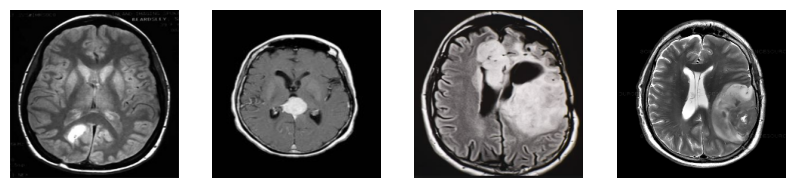

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.imshow(X[i], cmap="gray")
    plt.axis('off')
plt.show()

In [5]:
from sklearn.model_selection import train_test_split
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)

In [6]:
print ("Shape of an image in X_train: ", X_train[0].shape)
print ("Shape of an image in X_test: ", X_test[0].shape)
print ("Shape of an image in X_val: ", X_val[0].shape)
print ("Number of images in X_train: ", len(X_train))
print ("Number of images in X_test: ", len(X_test))
print ("Number of images in X_val: ", len(X_val))

Shape of an image in X_train:  (224, 224, 3)
Shape of an image in X_test:  (224, 224, 3)
Shape of an image in X_val:  (224, 224, 3)
Number of images in X_train:  151
Number of images in X_test:  51
Number of images in X_val:  51


In [7]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_val = le.transform(y_val)
y_test = le.transform(y_test)

print("y_train labels:", y_train[:5])


y_train labels: [1 1 0 0 1]


In [8]:
import numpy as np

#converting images into numpy arrays and normalizing
X_train = np.array(X_train) / 255.0
X_val = np.array(X_val) / 255.0
X_test = np.array(X_test) / 255.0

#converting labels into numpy arrays
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (151, 224, 224, 3)
y_train shape: (151,)
X_val shape: (51, 224, 224, 3)
y_val shape: (51,)
X_test shape: (51, 224, 224, 3)
y_test shape: (51,)


In [9]:
print(y_train[:5])

[1 1 0 0 1]


In [10]:
!pip install tensorflow

In [20]:
from keras.applications import MobileNetV2
from keras.applications.resnet50 import ResNet50


img_rows, img_cols = 224, 224


mbnt = MobileNetV2(weights = 'imagenet',
                 include_top = False,
                 input_shape = (img_rows, img_cols, 3))

#freezing vgg16 layers
for layer in mbnt.layers:
    layer.trainable = False


# printing our Mobilenet layers
for (i,layer) in enumerate(mbnt.layers):
    print(str(i) + " "+ layer.__class__.__name__, layer.trainable)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
0 InputLayer False
1 Conv2D False
2 BatchNormalization False
3 ReLU False
4 DepthwiseConv2D False
5 BatchNormalization False
6 ReLU False
7 Conv2D False
8 BatchNormalization False
9 Conv2D False
10 BatchNormalization False
11 ReLU False
12 ZeroPadding2D False
13 DepthwiseConv2D False
14 BatchNormalization False
15 ReLU False
16 Conv2D False
17 BatchNormalization False
18 Conv2D False
19 BatchNormalization False
20 ReLU False
21 DepthwiseConv2D False
22 BatchNormalization False
23 ReLU False
24 Conv2D False
25 BatchNormalization False
26 Add False
27 Conv2D False
28 BatchNormalization False
29 ReLU False
30 ZeroPadding2D False
31 DepthwiseConv2D False
32 BatchNormalization False
33 ReLU False
34 Conv2D False
35 BatchNormalization False
36 Conv2D False
37 BatchNormalization False
38 ReLU False
39 DepthwiseConv2D False
40 BatchNormalization False
41 ReLU False
42 Conv2D False
43 BatchNormalization False
44 Add False
45 Conv2D False
46 Batch

In [55]:
from keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D

def lw(bottom_model, num_classes):
  top_model = bottom_model.output
  top_model = GlobalAveragePooling2D()(top_model)
  top_model = Dense(1024,activation='relu')(top_model)
  top_model = Dropout(0.4)(top_model)
  # top_model = Dense(1024,activation='relu')(top_model)
  # top_model = Dropout(0.3)(top_model)
  top_model = Dense(512,activation='relu')(top_model)
  top_model = Dropout(0.3)(top_model)
  top_model = Dense(num_classes,activation='sigmoid')(top_model)
  return top_model

In [56]:
from keras.models import Model

num_classes = 1

FC_Head = lw(mbnt, num_classes)

model = Model(inputs = mbnt.input, outputs = FC_Head)

print(model.summary())

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_3[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 4,095,041 (15.62 MB)

 Trainable params: 1,837,057 (7.01 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

None


In [57]:
model.compile(optimizer='adam', loss = 'binary_crossentropy',metrics = ['accuracy'])

In [58]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# early_stop = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

history = model.fit(X_train, y_train,
                    batch_size=32,
                    epochs=15,
                    validation_data=(X_val, y_val),
                    callbacks=[checkpoint],
                    verbose=1)


Epoch 1/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5963 - loss: 0.7728

5/5 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step - accuracy: 0.6084 - loss: 0.7545 - val_accuracy: 0.7059 - val_loss: 0.4793
Epoch 2/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.8124 - loss: 0.3817 - val_accuracy: 0.7059 - val_loss: 0.6281
Epoch 3/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8647 - loss: 0.3017

5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.8651 - loss: 0.3030 - val_accuracy: 0.9412 - val_loss: 0.2260
Epoch 4/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8722 - loss: 0.2443

5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.8726 - loss: 0.2421 - val_accuracy: 0.9216 - val_loss: 0.2009
Epoch 5/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.8954 - loss: 0.2140 - val_accuracy: 0.7255 - val_loss: 0.6668
Epoch 6/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9246 - loss: 0.1436

5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 3s/step - accuracy: 0.9294 - loss: 0.1382 - val_accuracy: 0.9216 - val_loss: 0.1400
Epoch 7/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.9542 - loss: 0.1220 - val_accuracy: 0.7255 - val_loss: 1.1536
Epoch 8/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.9503 - loss: 0.0842 - val_accuracy: 0.8627 - val_loss: 0.3478
Epoch 9/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.9712 - loss: 0.0658 - val_accuracy: 0.7843 - val_loss: 0.7827
Epoch 10/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.9672 - loss: 0.0763 - val_accuracy: 0.8235 - val_loss: 0.4874
Epoch 11/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.9812 - loss: 0.0436 - val_accuracy: 0.7647 - val_loss: 0.9859
Epoch 12/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.9738 - loss: 0.0487 - val_accuracy: 0.8824 - val_loss: 0.2211
Epoch 13/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - accuracy: 1.0000 - loss: 0.0133 - val_accuracy: 0.7451 - val_loss: 1.1450
Epoch 14/15
5/5 

In [59]:
from tensorflow.keras.models import load_model

model = load_model("best_model.h5")

In [60]:
train_loss, train_accuracy = model.evaluate(X_train, y_train, verbose=1)
print(f"Final Training Loss: {train_loss:.4f}")
print(f"Final Training Accuracy: {train_accuracy:.4f}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.9367 - loss: 0.0963
Final Training Loss: 0.1185
Final Training Accuracy: 0.9272


In [61]:
val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=1)
print(f"Final Validation Loss: {val_loss:.4f}")
print(f"Final Validation Accuracy: {val_accuracy:.4f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.9269 - loss: 0.1402
Final Validation Loss: 0.1400
Final Validation Accuracy: 0.9216


In [62]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Final Test Loss: {test_loss:.4f}")
print(f"Final Test Accuracy: {test_accuracy:.4f}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 795ms/step - accuracy: 0.9165 - loss: 0.1639
Final Test Loss: 0.1586
Final Test Accuracy: 0.9216


In [63]:
predictions = model.predict(X_test)
print(predictions[:5])

2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step
[[1.3922701e-04]
 [9.9091917e-01]
 [9.9925894e-01]
 [2.8685320e-02]
 [9.9993885e-01]]


In [64]:
#converting above probabilities to classes
pred_labels = (predictions > 0.5).astype(int)
print(pred_labels[:5])

[[0]
 [1]
 [1]
 [0]
 [1]]


In [65]:
from sklearn.metrics import classification_report, confusion_matrix

print(confusion_matrix(y_test, pred_labels))
print(classification_report(y_test, pred_labels))

[[23  1]
 [ 3 24]]
              precision    recall  f1-score   support

           0       0.88      0.96      0.92        24
           1       0.96      0.89      0.92        27

    accuracy                           0.92        51
   macro avg       0.92      0.92      0.92        51
weighted avg       0.92      0.92      0.92        51



In [66]:
model.save("mobilenet_BT_model.keras")

In [70]:
import pickle
with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(le,f)